Last modified: Aug. 14th, 2025 (Opal Issan, oissan@ucsd.edu)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from QLT_equations.general_plasma_equations import Z_prime

In [2]:
%matplotlib inline
import matplotlib
font = {'family' : 'sans-serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

## Dispersion relation solver for MTSI
$$1 - \underbrace{\frac{\omega_{pe}^2}{\omega^2 }\frac{k_{\|}^2}{|\vec{k}|^2} + \frac{\omega_{pe}^2}{\Omega_{ce}^2}}_{\text{electron response}}
    = \underbrace{\frac{\omega_{pp}^2}{\alpha_{\| p}^2 k_{\perp}^2}  Z' \left( \frac{\omega - k_{\perp} U_{\perp, Dp}}{\alpha_{\| p} |k_{\perp}|}\right)}_{\text{ion response}}$$

In [3]:
def cold_electron_response(k_perp_, omega, omega_pe_, k_par_):
    return - (k_par_**2)/(k_par_**2 + k_perp_**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2


def ion_response(omega_pi_, alpha_i_, k_perp_, v_0_, n_, omega):
    return n_ * (omega_pi_ ** 2) / (alpha_i_ ** 2) / (k_perp_**2) * Z_prime(z=(omega - k_perp_ * v_0_) / (alpha_i_ * np.abs(k_perp_)))

In [15]:
# normalization
# time is normalized to the electron cyclotron frequency
# space is normalized to electron inertial length d_e

# match the NASA proposal
# cold electron density
ne = 1  # ne
# hot proton density
npH = 0.1  # ne
# cold proton density
npC = 1 - npH # ne

# mass ratios
mp_me = 100 # dimensionless
omega_pe = 2  # Omega_ce

# assume the plasma is isothermal Te=Tp=TO+=THe+
alpha_c_perp = np.sqrt(1e-4)  # d_e x Omega_ce
alpha_c_par = alpha_c_perp  # d_e x Omega_ce
alpha_p_par = alpha_c_perp / np.sqrt(mp_me)  # d_e x Omega_ce

# relative drift
UDp = -1.5 * alpha_p_par

In [17]:
def disp_k_(k_perp,
            k_par,
            npC_=npC,
            omega_pe_=omega_pe,
            mp_me_=mp_me,
            VDp_=UDp,
            alpha_p_par_=alpha_p_par):
    return lambda omega: 1 + cold_electron_response(k_perp_=k_perp, k_par_=k_par, omega=omega, omega_pe_=omega_pe_) \
                         - ion_response(omega_pi_=omega_pe_ / np.sqrt(mp_me_), n_=npC_, alpha_i_=alpha_p_par_, k_perp_=k_perp, v_0_=VDp_, omega=omega)

In [18]:
# quick check
k_perp = 1 * np.sqrt(1/mp_me) * np.sqrt(npC) / UDp   # d_e
k_par = -k_perp * 1e-1
omega_guess = 1/(2**(3/4)) * ((mp_me * np.sqrt(npC)*((k_par**2)/(k_perp**2)))**(1/3)) / np.sqrt(mp_me) # Omega_ce

sol_approx = scipy.optimize.newton(disp_k_(k_perp=k_perp, k_par=k_par), 
                                   omega_guess + 0.005j, tol=1e-16,
                                   maxiter=10000,
                                   x1=omega_guess * 0.99 + 1e-2j)
print(sol_approx)
print("k_perp rho_{e}", k_perp*alpha_c_perp/np.sqrt(2))
print("omega_k + i gamma = ", sol_approx * np.sqrt(mp_me))
print("dispersion residual approx = ", abs(disp_k_(k_perp=k_perp, k_par=k_par)(sol_approx)) )

(0.05240525455033582+0.01843299678226089j)
k_perp rho_{e} -0.4472135954999579
omega_k + i gamma =  (0.5240525455033582+0.1843299678226089j)
dispersion residual approx =  3.972054645195637e-15


In [19]:
omega_guess * np.sqrt(mp_me)

0.5842534086414334

\begin{equation*}
    k_{\perp} = \frac{\omega_{\mathrm{LH}} \sqrt{c_{cp}}}{U_{x, Dp}} \qquad \mathrm{and} \qquad \omega_{r} = \frac{1}{2^{\frac{4}{3}}} \left[\frac{m_{p}}{m_{e}} \sqrt{c_{cp}}\cos^2(\theta_{k})\right]^{\frac{1}{3}} \omega_{\mathrm{LH}}.
\end{equation*}

In [20]:
k_perp_ = np.linspace(0.02, 5, 30) * np.sqrt(1/mp_me) * np.sqrt(npC) / UDp # d_e
k_par_ = -np.linspace(0.002, 0.5, 20) * np.sqrt(1/mp_me) * np.sqrt(npC) / UDp # d_e
sol_ = np.ones((len(k_perp_), len(k_par_)), dtype="complex128") * np.nan

In [21]:
for ii in range(len(k_perp_)):
    for jj in range(len(k_par_)):
        try:
            sol_[ii, jj] = scipy.optimize.newton(disp_k_(k_perp=k_perp_[ii], k_par=k_par_[jj]),  omega_guess + 1e-2j, 
                                                 tol=1e-16, maxiter=10000, x1=omega_guess*0.5 + 1e-2j)
            error = abs(disp_k_(k_perp=k_perp_[ii], k_par=k_par_[jj])(sol_[ii, jj]))
            print("dispersion residual = ", error)
            if error > 1e-8:
                sol_[ii, jj] = np.nan
        except:
            print("An exception occurred")

dispersion residual =  2.3111219684699513e-13
dispersion residual =  9.525057929419242e-16
An exception occurred
dispersion residual =  1.688987916336406e-14
dispersion residual =  2.67841304690819e-15
dispersion residual =  9.991132920994517e-12
dispersion residual =  1.3877787807814457e-17
dispersion residual =  9.992021099414217e-12
dispersion residual =  9.020562075079397e-16
dispersion residual =  9.991993343838601e-12
dispersion residual =  9.993769700678001e-12
dispersion residual =  8.743006318923108e-16
dispersion residual =  9.020595511024828e-16
dispersion residual =  1.3877787807814457e-17
dispersion residual =  8.743006318923108e-16
dispersion residual =  1.3877787807814457e-17
dispersion residual =  1.3877787807814457e-17
dispersion residual =  9.992909298401457e-12
dispersion residual =  1.467969579972839e-17
dispersion residual =  9.989366163823758e-12
dispersion residual =  1.2549974758670805e-12
dispersion residual =  6.661444818753966e-16
dispersion residual =  1.078

/Users/oissan/PycharmProjects/EMIC_secondary_instability/QLT_equations/general_plasma_equations.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  return 1j * np.sqrt(np.pi) * wofz(z)
/opt/anaconda3/envs/rom/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:382: RuntimeWarning: invalid value encountered in scalar divide
  p = (-q1 / q0 * p0 + p1) / (1 - q1 / q0)
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_17482/2207632600.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return - (k_par_**2)/(k_par_**2 + k_perp_**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2


An exception occurred
An exception occurred
dispersion residual =  4.662937213098445e-14
dispersion residual =  9.015055998261575e-14
dispersion residual =  2.997834204286439e-15
dispersion residual =  9.547921005245467e-15
dispersion residual =  8.326673497162661e-16
dispersion residual =  6.161740175356738e-15
dispersion residual =  3.019806626980426e-14
dispersion residual =  2.9642954757491755e-14
dispersion residual =  8.493206138513993e-15
dispersion residual =  1.7210572307409014e-14
dispersion residual =  7.48871339830449e-15
dispersion residual =  3.337622223911057e-14
dispersion residual =  1.2531653923446488e-14
dispersion residual =  2.9878877150224525e-14
dispersion residual =  2.914335605302442e-16
dispersion residual =  3.040623308921272e-14
dispersion residual =  3.2752380802401556e-15
dispersion residual =  2.12344031247369e-13
An exception occurred
An exception occurred
dispersion residual =  2.5121479338940402e-14
dispersion residual =  3.275440170573378e-14
dispersi

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_17482/2207632600.py:2: RuntimeWarning: overflow encountered in scalar power
  return - (k_par_**2)/(k_par_**2 + k_perp_**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_17482/2207632600.py:2: RuntimeWarning: invalid value encountered in scalar power
  return - (k_par_**2)/(k_par_**2 + k_perp_**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2


An exception occurred
dispersion residual =  4.975329217620971
An exception occurred
dispersion residual =  1.1957467920563633e-15
dispersion residual =  8.005932084973442e-16
dispersion residual =  1.4054300946555646e-15
dispersion residual =  1.9860273225978185e-15
dispersion residual =  3.433175098891678e-15
dispersion residual =  9.992970910418892e-16
dispersion residual =  3.58724037616909e-15
dispersion residual =  1.6326319374041212e-15
dispersion residual =  4.379404155611337e-15
dispersion residual =  1.1102230246251565e-16
dispersion residual =  1.3322676295501878e-15
dispersion residual =  3.447059237218225e-15
dispersion residual =  7.021666937153402e-16
dispersion residual =  2.220446049250313e-16
dispersion residual =  4.965068306494546e-16
dispersion residual =  4.446439748506845e-15
dispersion residual =  1.4043333874306805e-15
An exception occurred
An exception occurred
An exception occurred
dispersion residual =  9.155133597044475e-16
dispersion residual =  4.44089209

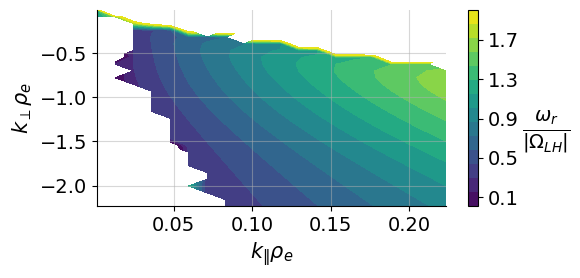

In [22]:
fig, ax = plt.subplots(figsize=(6, 3))
pos = ax.contourf(k_par_*alpha_c_perp/np.sqrt(2), k_perp_*alpha_c_perp/np.sqrt(2), sol_.real * np.sqrt(mp_me), vmin=1e-5, vmax=2, levels=np.linspace(1e-2, 2, 15))
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel(r'$\frac{\omega_{r}}{|\Omega_{LH}|}$', labelpad=20, rotation=0, fontsize=20)
ax.set_xlabel(r'$k_{\|}\rho_{e}$', fontsize=15)
ax.set_ylabel(r'$k_{\perp}\rho_{e}$', fontsize=15)
cbar.set_ticks([0.1, 0.5, 0.9, 1.3,  1.7])

#ax.set_xticks([180, 200, 220, 240])
#ax.set_xlim(175, 245)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(alpha=0.5)
plt.tight_layout()
# plt.savefig("figures/linear_theory/MTSI/omega_r_VD_" + str(round(UDp/alpha_p_par, 1)) + "_mpme_" + str(round(mp_me))+ ".png", dpi=300, bbox_inches='tight')

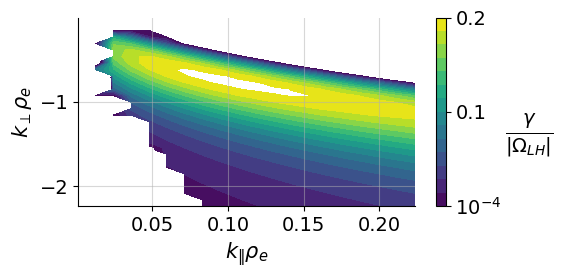

In [23]:
fig, ax = plt.subplots(figsize=(6, 3))
pos = ax.contourf(k_par_*alpha_c_perp/np.sqrt(2), k_perp_*alpha_c_perp/np.sqrt(2), 
                  sol_.imag * np.sqrt(mp_me), vmin=1E-4, vmax=0.2, levels=np.linspace(1e-4, 0.2, 15))

cbar = fig.colorbar(pos)
cbar.ax.set_ylabel(r'$\frac{\gamma}{|\Omega_{LH}|}$', labelpad=20, rotation=0, fontsize=20)
ax.set_xlabel(r'$k_{\|}\rho_{e}$', fontsize=15)
ax.set_ylabel(r'$k_{\perp}\rho_{e}$', fontsize=15)
cbar.set_ticks([1e-4, 0.1, 0.2])
cbar.set_ticklabels(["$10^{-4}$", "0.1", "0.2"])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(alpha=0.5)
plt.tight_layout()

#plt.savefig("figures/linear_theory/MTSI/gamma_VD_" + str(round(UDp/alpha_p_par, 1))  + "_mpme_" + str(round(mp_me))+ ".png", dpi=300, bbox_inches='tight')